In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
import imp
import time

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import sc_estimator

### Create AnnData object and attach the metadata for interferon dataset

This dataset was used for the demuxlet paper, https://www.nature.com/articles/nbt.4042

In [3]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/'

In [4]:
metadata = pd.read_csv(data_path + 'GSE96583_batch2.total.tsne.df.tsv', sep='\t')

In [5]:
ctrl_adata = sc.read_10x_mtx(data_path + 'ctrl_mtx/')
stim_adata = sc.read_10x_mtx(data_path + 'stim_mtx/')

In [6]:
both_barcodes = list(set(ctrl_adata.obs.index) & set(stim_adata.obs.index))
stim_adata.obs.index = [bc + '1' if bc in both_barcodes else bc for bc in stim_adata.obs.index.tolist()]

In [7]:
combined_X = sp.sparse.vstack([ctrl_adata.X, stim_adata.X])
combined_bc = ctrl_adata.obs.index.tolist() + stim_adata.obs.index.tolist()

In [8]:
adata = sc.AnnData(combined_X)
adata.obs.index = combined_bc
adata.var = ctrl_adata.var
adata.obs = adata.obs.join(metadata, how='left')
adata.obs['ind'] = adata.obs['ind'].astype('category')
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obsm['X_tsne'] = adata.obs[['tsne1', 'tsne2']].values
adata.write(data_path + 'interferon.h5ad')

... storing 'stim' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


In [9]:
adata.shape

(29065, 35635)

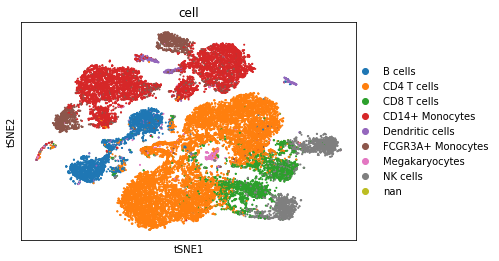

In [10]:
sc.pl.tsne(adata, color='cell')

### Isolate the CD4 T cell population

In [11]:
cd4_adata = adata[(adata.obs.cell == 'CD4 T cells') & (adata.obs.multiplets == 'singlet'), :].copy()

In [12]:
cd4_adata.write(data_path + 'interferon.cd4.h5ad')

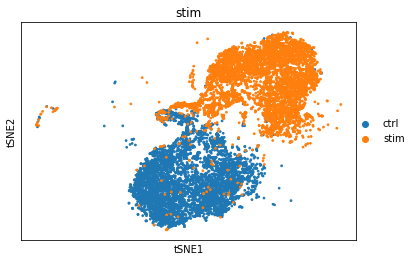

In [13]:
sc.pl.tsne(cd4_adata, color='stim')

### Grab ISG genes

In [14]:
cd4_adata_norm = cd4_adata.copy()
sc.pp.filter_genes(cd4_adata_norm, min_cells=5)
sc.pp.normalize_per_cell(cd4_adata_norm, counts_per_cell_after=1e4)
sc.pp.log1p(cd4_adata_norm)

In [15]:
sc.pp.filter_genes_dispersion(cd4_adata_norm, min_mean=0.0125, max_mean=3, min_disp=0.3)
sc.pp.scale(cd4_adata_norm, max_value=10)

In [16]:
for gene in cd4_adata_norm.var.index.tolist():
    if '.' not in gene and '-' not in gene:
        print(gene)

HES4
ISG15
TNFRSF18
TNFRSF4
SDF4
SSU72
TPRG1L
RERE
ENO1
CA6
CLSTN1
TARDBP
FBXO44
VPS13D
DHRS3
ZBTB17
FBXO42
NECAP2
NBL1
USP48
ID3
RPL11
RCAN3
SRRM1
C1orf63
LDLRAP1
STMN1
PDIK1L
SH3BGRL3
ARID1A
WASF2
IFI6
FAM76A
SNHG12
SRSF4
KPNA6
CCDC28B
MARCKSL1
ZBTB8OS
ZMYM1
ZMYM4
PSMB2
THRAP3
ZC3H12A
SNIP1
UTP11L
AKIRIN1
TRIT1
RLF
CTPS1
FOXJ3
CCDC23
SLC2A1
RPS8
PLK3
IPP
RNF11
TXNDC12
C1orf123
JUN
PDE4B
GADD45A
FAM73A
NEXN
DNAJB4
IFI44L
C1orf52
SH3GLB1
HS2ST1
PKN2
GTF2B
GBP1
GBP4
GBP5
LRRC8C
ZNF644
TGFBR3
GFI1
RPL5
DNTTIP2
AGL
PRPF38B
WDR47
GSTM3
CHI3L2
ST7L
SLC16A1
RSBN1
AP4B1
SIKE1
ATP1A1
CD58
WARS2
NOTCH2
PDE4DIP
TXNIP
PRKAB2
HIST2H2AC
APH1A
SETDB1
CDC42SE1
POGZ
THEM4
S100A11
S100A8
S100A6
S100A4
IL6R
SHC1
RUSC1
LMNA
ETV3
TAGLN2
PIGM
CD84
SLAMF1
HSPA6
ALDH9A1
SELL
PIGC
FASLG
CENPL
CACYBP
TOR1AIP1
RNASEL
RGS16
EDEM3
TPR
RGS1
RGS2
DENND1B
KDM5B
RABIF
BTG2
ZBED6
MDM4
RBBP5
DSTYK
NUAK2
CD55
TRAF3IP3
RCOR3
CENPF
GPATCH2
TAF1A
BROX
CNIH4
PARP1
ITPKB
C1orf35
IBA57
COA6
TARBP1
RBM34
LYST
CEP170
DESI2
ZNF6

### Get a list of ISGs from the Interferome search result

In [17]:
search_result = pd.read_csv(data_path + 'interferome_t_cells.txt', header=16, index_col=False, sep='\t')
search_result['Gene Name'] = search_result['Gene Name'].str.upper()
search_result['mag_fold_change'] = np.absolute(search_result['Fold Change'])
search_result = search_result[search_result['Inteferome Type'] == 'I']
search_result = search_result\
    .sort_values('mag_fold_change', ascending=False)\
    .drop_duplicates('Gene Name')
search_result = search_result[['Fold Change', 'Treatment Time', 'Gene Name', 'Description', 'mag_fold_change']]

In [18]:
isg_candidates = pd.concat([
    search_result[search_result['Fold Change'] > 0].head(30),
    search_result[search_result['Fold Change'] < 0].head(30)])
isg_genes = isg_candidates['Gene Name'].tolist()

In [19]:
#isg_candidates.to_csv(data_path + 'isg_candidates.csv')

In [24]:
len(isg_genes)

50

In [21]:
isg_genes[:5]

['IFI44L', 'IFIT3', 'IFIT1', 'IFI6', 'RSAD2']

### Get a list of IRFs just from the name for now

In [22]:
irf_genes = [gene for gene in cd4_adata.var.index if gene[:3] == 'IRF']

In [25]:
len(irf_genes)

12

In [23]:
irf_genes

['IRF6',
 'IRF2BP2',
 'IRF2',
 'IRF1',
 'IRF4',
 'IRF5',
 'IRF7',
 'IRF9',
 'IRF2BPL',
 'IRF8',
 'IRF2BP1',
 'IRF3']

In [699]:
[gene for gene in cd4_adata_norm.var.index if gene[:3] == 'IRF']

['IRF1', 'IRF7', 'IRF2BPL', 'IRF8']

### Check some correlations in single cell data

In [129]:
cd4_adata_norm = cd4_adata.copy()
sc.pp.normalize_per_cell(cd4_adata_norm, counts_per_cell_after=1e4)
sc.pp.log1p(cd4_adata_norm)
sc.pp.scale(cd4_adata_norm, max_value=10)

/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1142: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(var)
/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1148: RuntimeWarning: divide by zero encountered in true_divide
  X /= scale
/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1148: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:965: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


In [130]:
#cd4_adata_norm.write(data_path + 'interferon.cd4.norm.h5ad')

In [131]:
cxcl10_exp = cd4_adata_norm[:, 'CXCL10'].X.reshape(-1)
ccl5_exp = cd4_adata_norm[:, 'CCL5'].X.reshape(-1)
ccl3_exp = cd4_adata_norm[:, 'CCL3'].X.reshape(-1)
irf7_exp = cd4_adata_norm[:, 'IRF7'].X.reshape(-1)
irf4_exp = cd4_adata_norm[:, 'IRF4'].X.reshape(-1)
OAS1_exp = cd4_adata_norm[:, 'OAS1'].X.reshape(-1)

(0.33326358, 6.728614120857142e-268)


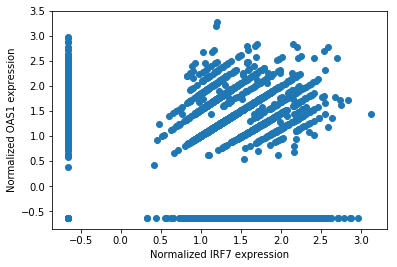

In [133]:
plt.scatter(irf7_exp, OAS1_exp)
plt.xlabel('Normalized IRF7 expression')
plt.ylabel('Normalized OAS1 expression')

print(stats.pearsonr(irf7_exp, OAS1_exp))

(-0.005310951, 0.5883249335774889)


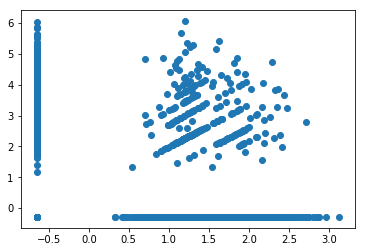

In [832]:
plt.scatter(irf7_exp, ccl5_exp)
print(stats.pearsonr(irf7_exp, ccl5_exp))

(0.19816679, 1.7202134814153068e-92)


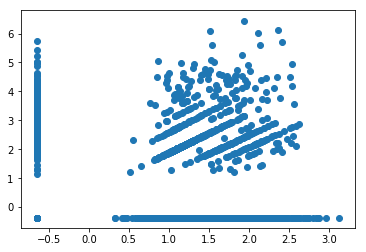

In [708]:
plt.scatter(irf7_exp, cxcl10_exp)
print(stats.pearsonr(irf7_exp, cxcl10))

(0.028776474, 0.0033533840334995704)


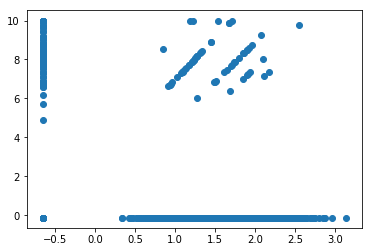

In [709]:
plt.scatter(irf7_exp, ccl3_exp)
print(stats.pearsonr(irf7_exp, ccl3))

### Create the scEstimator

In [810]:
imp.reload(sc_estimator)

<module 'sc_estimator' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py'>

In [811]:
estimator = sc_estimator.SingleCellEstimator(cd4_adata, group_label='stim')

### CCL3 and IRF7

In [812]:
estimator.compute_1d_params('IRF7', group='stim', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)

<Figure size 288x216 with 0 Axes>

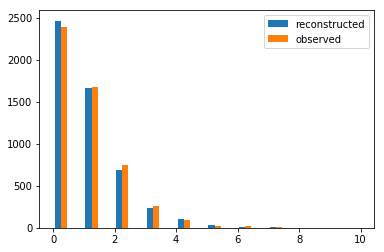

In [813]:
plt.figure(figsize=(4, 3))
plt.figure('IRF7 Reconstruction')
plt.hist(
    [estimator.generate_reconstructed_obs('IRF7', group='stim'),
    cd4_adata[cd4_adata.obs.stim == 'stim', :][:, 'IRF7'].X], bins=20);
plt.legend(['reconstructed', 'observed'])

In [814]:
estimator.compute_1d_params('CCL3', group='stim', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=60)

/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:78: RuntimeWarning: invalid value encountered in double_scalars
  table[x, z] = self._rv_pmf(z, mu, sigma) * stats.binom.pmf(x, z, p) / px_table[x]


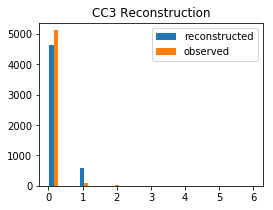

In [815]:
#estimator.compute_1d_params('CCL5', group='stim', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)
plt.figure(figsize=(4, 3))
plt.title('CC3 Reconstruction')
plt.hist(
    [estimator.generate_reconstructed_obs('CCL3', group='stim'),
    cd4_adata[cd4_adata.obs.stim == 'stim', :][:, 'CCL3'].X], bins=20);
plt.legend(['reconstructed', 'observed'])

In [816]:
estimator.compute_2d_params('IRF7', 'CCL3', group='stim', search_num=100)

/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:138: RuntimeWarning: invalid value encountered in log
  for j in range(self.max_latent):
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:139: RuntimeWarning: invalid value encountered in log
  px_table[i][j] = self._calculate_px_2d(i, j, mu, sigma, p, method)
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:140: RuntimeWarning: invalid value encountered in log
  return px_table


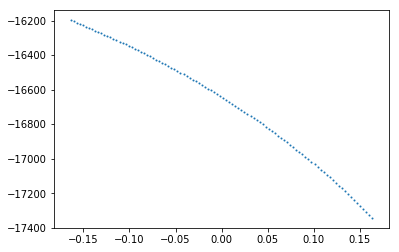

In [817]:
plt.scatter(estimator.param_sweep_2d['CCL3*IRF7'], estimator.log_likelihood_2d['CCL3*IRF7'], s=1)

### CXCL10 and IRF7

In [800]:
mu = 1.2
sigma = 0.5
x = 2

In [801]:
stats.norm.cdf(np.log(x), loc=mu, scale=sigma)

0.1553616162914675

In [802]:
stats.lognorm.cdf(x, s=sigma, scale=np.exp(mu))

0.15536161629146772

In [806]:
stats.multivariate_normal.pdf([np.log(0.5), np.log(0.10)])

array([0.31374804, 0.02815902])

In [532]:
estimator.compute_1d_params('CXCL10', group='stim', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)

/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:48: RuntimeWarning: invalid value encountered in greater
  lnx = np.log(x[x > 0])
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:49: RuntimeWarning: invalid value encountered in greater
  muhat = np.average(lnx, weights=w[x > 0])
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:50: RuntimeWarning: invalid value encountered in greater
  varhat = np.average((lnx - muhat)**2, weights=w[x > 0])


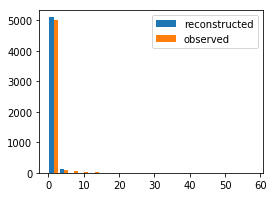

In [533]:
#estimator.compute_1d_params('CCL5', group='stim', initial_sigma_hat = 5, initial_mu_hat=5, num_iter=200)
plt.figure(figsize=(4, 3))
plt.hist(
    [estimator.generate_reconstructed_obs('CXCL10', group='stim'),
    cd4_adata[cd4_adata.obs.stim == 'stim', :][:, 'CXCL10'].X], bins=20);
plt.legend(['reconstructed', 'observed'])

In [748]:
start = time.time()
estimator = sc_estimator.SingleCellEstimator(cd4_adata, group_label='stim')
estimator.param_1d = {'IRF7': {'stim': (1.9449282445301572, 0.6670143637172984, 0.1, 5228)},
 'CCL3': {'stim': (0.09834581227350142, 0.2451257768440796, 0.1, 5228)},
 'CXCL10': {'stim': (1.1969403935689256, 0.8533430441952176, 0.1, 5228)}}
estimator.compute_2d_params('IRF7', 'CXCL10', group='stim', search_num=200)
print(time.time() - start)

/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:110: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(stats.multivariate_normal.pdf(np.log(x), mean=mean, cov=cov)/denom)
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:110: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(stats.multivariate_normal.pdf(np.log(x), mean=mean, cov=cov)/denom)


37.90917134284973


In [743]:
plt.scatter(estimator.param_sweep_2d['CXCL10*IRF7'], estimator.log_likelihood_2d['CXCL10*IRF7'], s=1)

KeyError: 'CXCL10*IRF7'

### scEstimator results

In [68]:
estimator = sc_estimator.SingleCellEstimator(cd4_adata, group_label='stim')
estimator.import_model(data_path + 'model_save/param_2d_307_50.pkl')

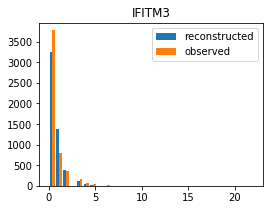

In [69]:
gene = 'IFITM3'
plt.figure(figsize=(4, 3))
plt.title(gene)
plt.hist(
    [estimator.generate_reconstructed_obs(gene, group='stim'),
    cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X], bins=30);
plt.legend(['reconstructed', 'observed'])

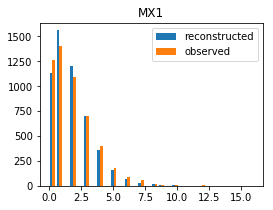

In [70]:
gene = 'MX1'
plt.figure(figsize=(4, 3))
plt.title(gene)
plt.hist(
    [estimator.generate_reconstructed_obs(gene, group='stim'),
    cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X], bins=30);
plt.legend(['reconstructed', 'observed'])

In [ ]:
['IRF6',
 'IRF2BP2',
 'IRF2',
 'IRF1',
 'IRF4',
 'IRF5',
 'IRF7',
 'IRF9',
 'IRF2BPL',
 'IRF8',
 'IRF2BP1',
 'IRF3']

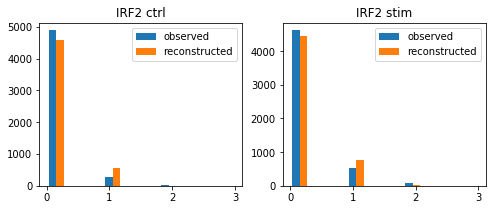

In [92]:
gene = 'IRF2'

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.title(gene + ' ctrl')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'ctrl', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='ctrl')], bins=10);
plt.legend(['observed', 'reconstructed'])
plt.subplot(1, 2, 2)
plt.title(gene + ' stim')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='stim')], bins=10);
plt.legend(['observed', 'reconstructed'])



In [91]:
estimator.differential_expression('IRF2', groups=('ctrl', 'stim'))
estimator.diff_exp['IRF2']

{('ctrl', 'stim'): (-43.27976751474702, 8032.8946065316295, 0.0)}

Text(0.5,0,'Log(Expression)')

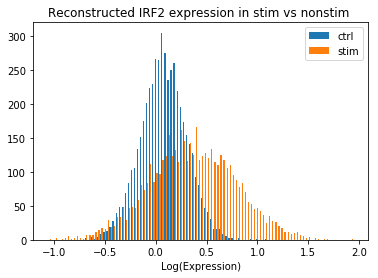

In [94]:
plt.hist([
    stats.norm.rvs(
        loc=estimator.param_1d['IRF2']['ctrl'][0], 
        scale=estimator.param_1d['IRF2']['ctrl'][1], size=5000),
    stats.norm.rvs(
        loc=estimator.param_1d['IRF2']['stim'][0], 
        scale=estimator.param_1d['IRF2']['stim'][1], size=5000)
    ], bins=100);
plt.title('Reconstructed IRF2 expression in stim vs nonstim ')
plt.legend(['ctrl', 'stim'])
plt.xlabel('Log(Expression)')

In [89]:
stats.ttest_ind(cd4_adata[cd4_adata.obs.stim == 'ctrl', :][:, gene].X, 
                cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X,
                equal_var=False)

Ttest_indResult(statistic=-12.354543844113504, pvalue=8.998606166584012e-35)

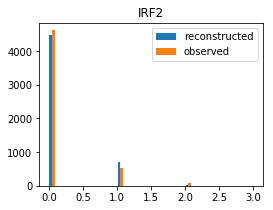

In [71]:
gene = 'IRF2'
plt.figure(figsize=(4, 3))
plt.title(gene)
plt.hist(
    [estimator.generate_reconstructed_obs(gene, group='stim'),
    cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X], bins=30);
plt.legend(['reconstructed', 'observed'])

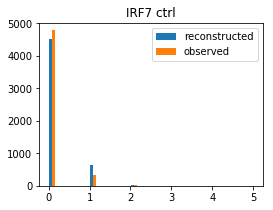

In [98]:
gene = 'IRF7'
plt.figure(figsize=(4, 3))
plt.title(gene + ' ctrl')
plt.hist(
    [estimator.generate_reconstructed_obs(gene, group='ctrl'),
    cd4_adata[cd4_adata.obs.stim == 'ctrl', :][:, gene].X], bins=30);
plt.legend(['reconstructed', 'observed'])

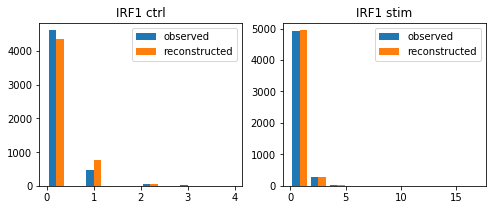

In [160]:
gene = 'IRF1'

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.title(gene + ' ctrl')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'ctrl', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='ctrl')], bins=10);
plt.legend(['observed', 'reconstructed'])
plt.subplot(1, 2, 2)
plt.title(gene + ' stim')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='stim')], bins=10);
plt.legend(['observed', 'reconstructed'])



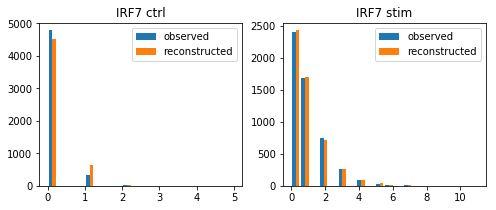

In [110]:
gene = 'IRF7'

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.title(gene + ' ctrl')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'ctrl', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='ctrl')], bins=20);
plt.legend(['observed', 'reconstructed'])
plt.subplot(1, 2, 2)
plt.title(gene + ' stim')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='stim')], bins=20);
plt.legend(['observed', 'reconstructed'])
#plt.xlim(0, 10)



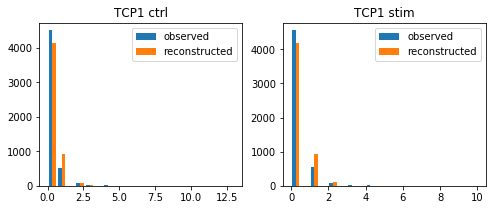

In [109]:
gene = 'TCP1'

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)

plt.title(gene + ' ctrl')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'ctrl', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='ctrl')], bins=20);
plt.legend(['observed', 'reconstructed'])
plt.subplot(1, 2, 2)
plt.title(gene + ' stim')
plt.hist(
    [cd4_adata[cd4_adata.obs.stim == 'stim', :][:, gene].X, estimator.generate_reconstructed_obs(gene, group='stim')], bins=20);
plt.legend(['observed', 'reconstructed'])
#plt.xlim(0, 10)



### Do some 2D runs

In [70]:
imp.reload(sc_estimator)

<module 'sc_estimator' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py'>

In [93]:
estimator = sc_estimator.SingleCellEstimator(cd4_adata, group_label='stim')
estimator.import_model('save.pkl')
del estimator.param_2d['stim']

In [54]:
irfs = ['IRF1', 'IRF7']
isgs = ['TCP1', 'MX1', 'OAS1', 'CXCL10', 'CD7']

In [55]:
len(list(itertools.product(irfs, isgs)))

10

In [111]:
estimator.param_2d

{'IRF1*TCP1': {'ctrl': 0.22968489036852152, 'stim': 0.3830140353644846},
 'IRF1*MX1': {'ctrl': 0.12780503364832033, 'stim': 0.10253455518882859},
 'IRF1*OAS1': {'ctrl': 0.08573924411573865, 'stim': 0.23052286426628016},
 'CXCL10*IRF1': {'ctrl': 0.03547576672860761, 'stim': 0.27891720278425014},
 'CD7*IRF1': {'ctrl': -0.32938655502760433, 'stim': -0.34281572153103795},
 'IRF7*TCP1': {'ctrl': -0.08446182778744159, 'stim': -0.36710414716038375},
 'IRF7*MX1': {'ctrl': 0.10012539723020476, 'stim': 0.32103299811819747},
 'IRF7*OAS1': {'ctrl': 0.06717009205543645, 'stim': 0.2916503757287144},
 'CXCL10*IRF7': {'ctrl': 0.027792530030718406, 'stim': 0.17434653722914706},
 'CD7*IRF7': {'ctrl': -0.25804898854905955, 'stim': -0.03399058109496922}}

In [96]:
for irf, isg in itertools.product(irfs, isgs):
    
    estimator.compute_2d_params(irf, isg, 'ctrl', search_num=50)
    estimator.compute_2d_params(irf, isg, 'stim', search_num=50)

Already computed!
Already computed!
Already computed!


/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:138: RuntimeWarning: invalid value encountered in log
  lower_left_cdf = np.nan_to_num(stats.multivariate_normal.cdf(np.log(lower_left), mean=mean, cov=cov))
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:139: RuntimeWarning: invalid value encountered in log
  upper_left_cdf = np.nan_to_num(stats.multivariate_normal.cdf(np.log(upper_left), mean=mean, cov=cov))
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/sc_estimator.py:140: RuntimeWarning: invalid value encountered in log
  lower_right_cdf = np.nan_to_num(stats.multivariate_normal.cdf(np.log(lower_right), mean=mean, cov=cov))


Already computed!
Already computed!
Already computed!
Already computed!
Already computed!
Already computed!
Already computed!
Already computed!


In [97]:
estimator.export_model('save2.pkl')

In [118]:
estimator.param_sweep_2d['IRF7*OAS1']['ctrl'][estimator.log_likelihood_2d['IRF7*OAS1']['stim'] == estimator.log_likelihood_2d['IRF7*OAS1']['stim'].max()]

array([0.045237])

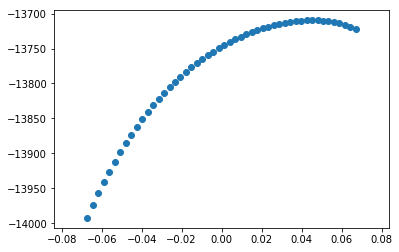

In [114]:
plt.scatter(estimator.param_sweep_2d['IRF7*OAS1']['ctrl'], estimator.log_likelihood_2d['IRF7*OAS1']['stim'])

In [117]:
0.20334570868754406*0.33032461067889235

0.06717009205543645

In [116]:
estimator.param_1d['OAS1']

{'stim': (2.0272791317607695, 0.6488568352623092, 0.1, 5228),
 'ctrl': (0.06523135302514547, 0.20334570868754406, 0.1, 5161)}

In [115]:
estimator.param_1d['IRF7']

{'stim': (1.9445786427375402, 0.667414743856715, 0.1, 5228),
 'ctrl': (0.20219131419771152, 0.33032461067889235, 0.1, 5161)}

In [120]:
estimator.param_2d['IRF7*OAS1']['ctrl'] = 0.045237

In [126]:
for gene_pair in estimator.param_2d.keys():
    
    cov = estimator.param_sweep_2d[gene_pair]['ctrl'][estimator.log_likelihood_2d[gene_pair]['stim'] == estimator.log_likelihood_2d[gene_pair]['stim'].max()][0]
    
    estimator.param_2d[gene_pair]['ctrl'] = cov

In [127]:
estimator.param_2d

{'IRF1*TCP1': {'ctrl': 0.22968489036852152, 'stim': 0.3830140353644846},
 'IRF1*MX1': {'ctrl': 0.03912398989234295, 'stim': 0.10253455518882859},
 'IRF1*OAS1': {'ctrl': 0.04374451230394828, 'stim': 0.23052286426628016},
 'CXCL10*IRF1': {'ctrl': 0.01665189050526479, 'stim': 0.27891720278425014},
 'CD7*IRF1': {'ctrl': -0.19494306317960258, 'stim': -0.34281572153103795},
 'IRF7*TCP1': {'ctrl': -0.1799404157210712, 'stim': -0.36710414716038375},
 'IRF7*MX1': {'ctrl': 0.10012539723020476, 'stim': 0.32103299811819747},
 'IRF7*OAS1': {'ctrl': 0.045237000772028635, 'stim': 0.2916503757287144},
 'CXCL10*IRF7': {'ctrl': 0.008507917356342373, 'stim': 0.17434653722914706},
 'CD7*IRF7': {'ctrl': -0.015798917666268952, 'stim': -0.03399058109496922}}

In [121]:
estimator.param_2d

{'IRF1*TCP1': {'ctrl': 0.22968489036852152, 'stim': 0.3830140353644846},
 'IRF1*MX1': {'ctrl': 0.12780503364832033, 'stim': 0.10253455518882859},
 'IRF1*OAS1': {'ctrl': 0.08573924411573865, 'stim': 0.23052286426628016},
 'CXCL10*IRF1': {'ctrl': 0.03547576672860761, 'stim': 0.27891720278425014},
 'CD7*IRF1': {'ctrl': -0.32938655502760433, 'stim': -0.34281572153103795},
 'IRF7*TCP1': {'ctrl': -0.08446182778744159, 'stim': -0.36710414716038375},
 'IRF7*MX1': {'ctrl': 0.10012539723020476, 'stim': 0.32103299811819747},
 'IRF7*OAS1': {'ctrl': 0.045237, 'stim': 0.2916503757287144},
 'CXCL10*IRF7': {'ctrl': 0.027792530030718406, 'stim': 0.17434653722914706},
 'CD7*IRF7': {'ctrl': -0.25804898854905955, 'stim': -0.03399058109496922}}

max: 0.22968489036852152
[[0.17778261 0.22968489]
 [0.22968489 0.29673965]]
max: 0.3830140353644846
[[0.48488906 0.38301404]
 [0.38301404 0.30254292]]
max: 0.12780503364832033
[[0.17778261 0.03912399]
 [0.03912399 0.09187696]]
max: 0.3349462136168401
[[0.48488906 0.10253456]
 [0.10253456 0.23137038]]
max: 0.08573924411573865
[[0.17778261 0.04374451]
 [0.04374451 0.04134948]]
max: 0.45182481396190904
[[0.48488906 0.23052286]
 [0.23052286 0.42101519]]
max: 0.03547576672860761
[[0.00707904 0.01665189]
 [0.01665189 0.17778261]]
max: 0.5942149102794894
[[0.72818998 0.2789172 ]
 [0.2789172  0.48488906]]
max: 0.32938655502760433
[[ 0.61027061 -0.19494306]
 [-0.19494306  0.17778261]]
max: 0.5792403570696848
[[ 0.69195083 -0.34281572]
 [-0.34281572  0.48488906]]
max: 0.1799404157210712
[[ 0.10911435 -0.17994042]
 [-0.17994042  0.29673965]]
max: 0.36710414716038375
[[ 0.44544244 -0.36710415]
 [-0.36710415  0.30254292]]
max: 0.10012539723020476
[[0.10911435 0.1001254 ]
 [0.1001254  0.09187696]]
m

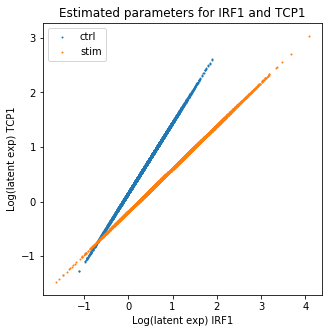

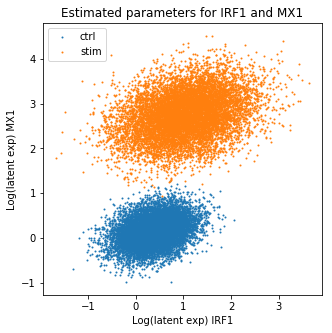

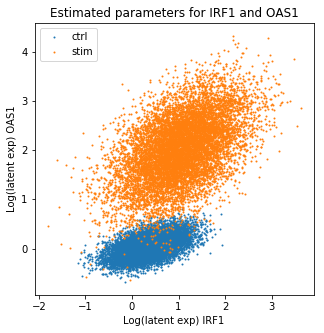

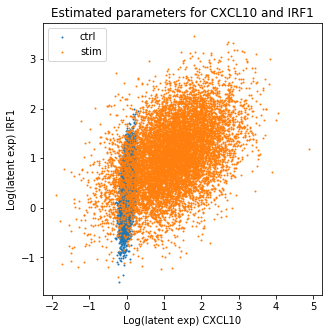

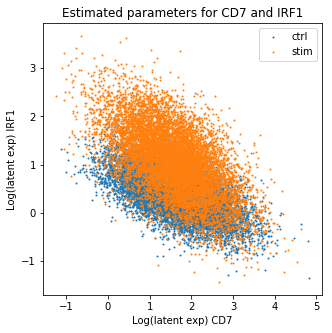

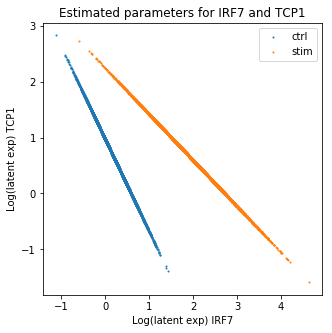

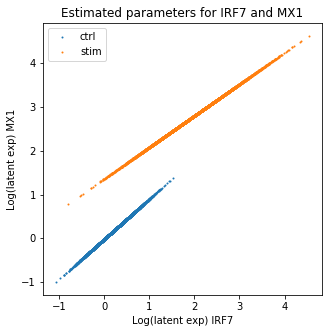

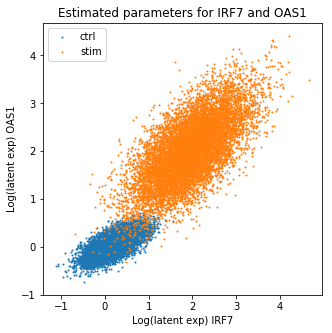

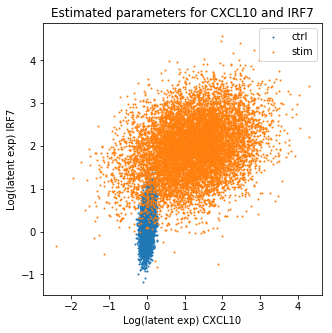

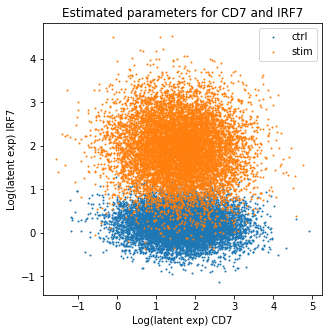

In [128]:
for irf, isg in itertools.product(irfs, isgs):
    
    gene_1 = irf if irf < isg else isg
    gene_2 = irf if irf > isg else isg
    
    mu_1 = np.array([estimator.param_1d[gene_1]['ctrl'][0], estimator.param_1d[gene_2]['ctrl'][0]])
    mu_2 = np.array([estimator.param_1d[gene_1]['stim'][0], estimator.param_1d[gene_2]['stim'][0]])
    cov_1 = np.array(
        [
            [estimator.param_1d[gene_1]['ctrl'][1]**2, estimator.param_2d[gene_1 + '*' + gene_2]['ctrl']],
            [estimator.param_2d[gene_1 + '*' + gene_2]['ctrl'], estimator.param_1d[gene_2]['ctrl'][1]**2]
        ])
    cov_2 = np.array(
        [
            [estimator.param_1d[gene_1]['stim'][1]**2, estimator.param_2d[gene_1 + '*' + gene_2]['stim']],
            [estimator.param_2d[gene_1 + '*' + gene_2]['stim'], estimator.param_1d[gene_2]['stim'][1]**2]
        ])
    
    print('max:', np.sqrt(cov_1[0, 0]) * np.sqrt(cov_1[1, 1]))
    print(cov_1)
    print('max:', np.sqrt(cov_2[0, 0]) * np.sqrt(cov_2[1, 1]))
    print(cov_2)
    
    draws1 = stats.multivariate_normal.rvs(mu_1, cov_1, 10000)
    draws2 = stats.multivariate_normal.rvs(mu_2, cov_2, 10000)
    
    plt.figure(figsize=(5, 5))
    plt.scatter(draws1[:, 0], draws1[:, 1], s=1)
    plt.scatter(draws2[:, 0], draws2[:, 1], s=1)
    plt.title('Estimated parameters for {} and {}'.format(gene_1, gene_2))
    plt.xlabel('Log(latent exp) {}'.format(gene_1));
    plt.ylabel('Log(latent exp) {}'.format(gene_2));
    plt.legend(['ctrl', 'stim'])